In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

In [2]:
### First I try to create buffer area regarding criterions of suitabilit index ### 
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')
lccs_resolution = 300 ##meters

## only forest ## 
xr_landuse['forest'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170])),1,0)
df_landuse_forest = xr_landuse['forest'].to_dataframe()
df_landuse_forest.reset_index(inplace=True)

df_landuse_forest = gpd.GeoDataFrame(df_landuse_forest, geometry =gpd.points_from_xy(df_landuse_forest['lon'],df_landuse_forest['lat']))
df_landuse_forest.crs = {'init': 'epsg:4326'}
df_landuse_forest = df_landuse_forest.to_crs({'init': 'epsg:3857'})
df_landuse_distancetoforest = df_landuse_forest
df_landuse_forest = df_landuse_forest.loc[df_landuse_forest['forest'] == 1]

## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.to_crs({'init': 'epsg:3857'})
boundaries = boundaries.geometry.unary_union

## I filter out area outside of THailand ## 
df_landuse_forest = df_landuse_forest.loc[df_landuse_forest.within(boundaries)]
df_landuse_forest.reset_index(inplace=True,drop=True)


df_distancetoforest = gpd.sjoin_nearest(df_landuse_distancetoforest,df_landuse_forest,distance_col="distance",how='left')

print(df_distancetoforest.columns)
for i in df_distancetoforest.columns:
    if i not in (['lon_left','lat_left','forest_left','distance','geometry']):
        df_distancetoforest = df_distancetoforest.drop(columns=i)

df_distancetoforest = df_distancetoforest.rename(columns= {'lon_left' : 'lon'})
df_distancetoforest = df_distancetoforest.rename(columns= {'lat_left' : 'lat'})
df_distancetoforest = df_distancetoforest.rename(columns= {'forest_left' : 'SI_DtoForest'})

df_distancetoforest.reset_index(inplace=True,drop=True)
try: 
    df_distancetoforest = df_distancetoforest.drop(columns=['geometry'])
except:
    None

print(df_distancetoforest.columns)
df_distancetoforest = df_distancetoforest.groupby(['lat', 'lon']).agg('mean')
df_distancetoforest.reset_index(inplace=True)
df_distancetoforest = df_distancetoforest.set_index(['lat', 'lon'])
print(df_distancetoforest)

xr_distancetoforest = xr.Dataset.from_dataframe(df_distancetoforest)
print(xr_distancetoforest)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the prefe

Index(['lat_left', 'lon_left', 'forest_left', 'geometry', 'index_right',
       'lat_right', 'lon_right', 'forest_right', 'distance'],
      dtype='object')
Index(['lat', 'lon', 'SI_DtoForest', 'distance'], dtype='object')
                      SI_DtoForest       distance
lat       lon                                    
5.615278  97.345833            0.0  268766.963682
          97.348611            0.0  268640.104012
          97.351389            0.0  268513.540507
          97.354167            0.0  268387.273585
          97.356944            0.0  268261.303666
...                            ...            ...
20.462500 105.623611           0.0  321389.312904
          105.626389           0.0  321568.217197
          105.629167           1.0  321747.319193
          105.631944           1.0  321926.618564
          105.634722           1.0  322106.114980

[15957810 rows x 2 columns]
<xarray.Dataset>
Dimensions:       (lat: 5346, lon: 2985)
Coordinates:
  * lat           (lat) flo

In [3]:
df_distancetoforest = xr_distancetoforest.to_dataframe()
df_distancetoforest.reset_index(inplace=True)
df_distancetoforest = gpd.GeoDataFrame(df_distancetoforest, geometry =gpd.points_from_xy(df_distancetoforest['lon'],df_distancetoforest['lat']))
df_distancetoforest = df_distancetoforest.drop(columns='SI_DtoForest')

df_distancetoforest['SI_Solar'] = 0
df_distancetoforest['SI_Wind'] = 0

df_distancetoforest['SI_Wind'].loc[df_distancetoforest['distance'] < (1500+lccs_resolution)] = 0
df_distancetoforest['SI_Wind'].loc[df_distancetoforest['distance'] >= (1500+lccs_resolution)] = 3

df_distancetoforest['SI_Solar'].loc[df_distancetoforest['distance'] < (1000+lccs_resolution)] = 0
df_distancetoforest['SI_Solar'].loc[df_distancetoforest['distance'] >= (1000+lccs_resolution)] = 3

xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_landuse_suitability_index= xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))

df_distancetoforest['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
df_distancetoforest['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0

print(df_distancetoforest)

C:\Users\basna\AppData\Local\Temp\ipykernel_19188\3900727175.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoforest['SI_Wind'].loc[df_distancetoforest['distance'] < (1500+lccs_resolution)] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_19188\3900727175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoforest['SI_Wind'].loc[df_distancetoforest['distance'] >= (1500+lccs_resolution)] = 3
C:\Users\basna\AppData\Local\Temp\ipykernel_19188\3900727175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  268766.963682    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268640.104012    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268513.540507    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268387.273585    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268261.303666    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  321389.312904  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  321568.217197  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  321747.319193  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  321926.618564  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  322106.114980  POINT (105.63472 20.46250)   

          SI_Solar  SI_Wind  
0                0        0  
1  

C:\Users\basna\AppData\Local\Temp\ipykernel_19188\3900727175.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoforest['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_19188\3900727175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoforest['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0


In [4]:
print(df_distancetoforest)
try: 
    df_distancetoforest = df_distancetoforest.drop(columns=['distance','geometry'])
except:
    None

df_distancetoforest = df_distancetoforest.groupby(['lat', 'lon']).agg('mean')
df_distancetoforest.reset_index(inplace=True)
df_distancetoforest = df_distancetoforest.set_index(['lat', 'lon'])


xr_distancetoforest = xr.Dataset.from_dataframe(df_distancetoforest)
xr_distancetoforest.to_netcdf(path='Output\\xr_SI_Distancetoforest.nc')
print(xr_distancetoforest)

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  268766.963682    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268640.104012    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268513.540507    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268387.273585    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268261.303666    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  321389.312904  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  321568.217197  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  321747.319193  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  321926.618564  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  322106.114980  POINT (105.63472 20.46250)   

          SI_Solar  SI_Wind  
0                0        0  
1  

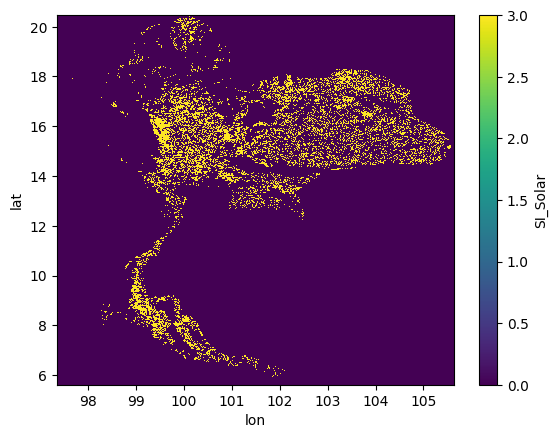

In [5]:
xr_distancetoforest['SI_Solar'].plot()

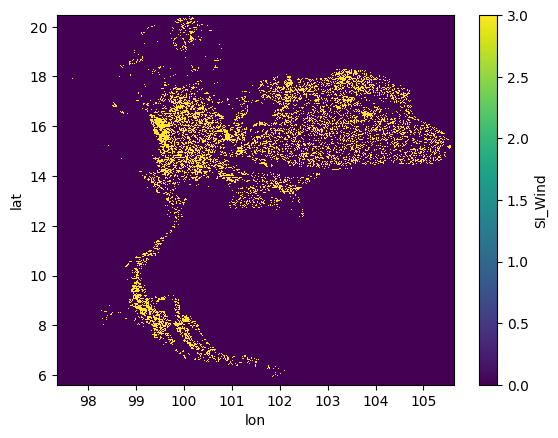

In [6]:
xr_distancetoforest['SI_Wind'].plot()